# Basic LSP modeling
This is an attempt to replicate Figures 1 and 2 from [1], then adapting it to the 1.06 micron wavelength.

In [23]:
import numpy as np
import scipy.constants as const
import scipy.optimize as sciopt
import matplotlib.pyplot as plt
import constants as c
import saha
import CEA
from partition import Partition

CO2_freq = const.c/10.6e-6
Fiber_freq = const.c/1.07e-6

SAVE_PLOT = True

## Figure 1: Degree of Ionization and Electron Density
For starters, we need to know the electron number density of our plasma. Enter the Saha equation.

### Simplified Saha Equation
Using a simplified form of Saha's equation, as given in CHEE 543, calculating degree of ionization, then electron density at... 1 atm??

$$
    \frac{\alpha_\mathrm{i}^2}{1-\alpha_\mathrm{i}^2} \approx 3.2 \times 10^{-2} \frac{T^{5/2}}{p}\exp{\left(-\frac{eE_\mathrm{i}}{k_BT}\right)}
$$

With $\alpha_\mathrm{i}$ related to the particle densities as follows:

$$
    \alpha_\mathrm{i} = \frac{n_\mathrm{i}}{n_\mathrm{i}+n_\mathrm{n}}
$$

This is implemented in `saha.degreeIonization_simple`.  
Problem: It appears to overestimate the number density past ~10 000 K.

### The "Real" Saha Equation
The Saha equation is presented in a few different forms. The one used by Akarapu et al. is as follows:

$$
    \frac{n_\mathrm{e}^2}{n_0-n_\mathrm{e}} = \frac{n_\mathrm{e}^2}{n_\mathrm{Ar}} = \frac{2}{\Lambda^3}\frac{g_{\mathrm{Ar}^+}}{g_{\mathrm{Ar}}}\exp{\left(-\frac{E_\mathrm{ion, Ar}}{k_\mathrm{B}T}\right)}
$$

Where $\Lambda$ is the thermal DeBroglie wavelength:
$$
    \Lambda = \sqrt{\frac{h^2}{2\pi m_\mathrm{e}k_\mathrm{B}T}}
$$

In [2]:
Ei_Argon = 15.759610  # eV
R_argon = 208.1  # J kg^-1 K^-1
M_argon = 39.95  # kg kmol^-1
init_temp = 300  # K
temperature = np.linspace(1000, 25000, 100)  # K
# pressure = 1*101300  # Pa
pressure = 10e5 # Pa
gas_species = ['Ar I', 'Ar II']

# rho = pressure/(R_argon*init_temp)
# n_0 = 1000*const.Avogadro*rho/M_argon

# n_0 = pressure*const.N_A/(const.R*init_temp)  # only valid for constant volume
n_0 = pressure*const.N_A/(const.R*temperature)
print(const.N_A)

6.02214076e+23


#### Computing partition functions
From [2], the ratio of partition functions can be determined from NIST and interpolated as follows:
$$
    \frac{g_\mathrm{Ar}}{g_{\mathrm{Ar}^+}} = -2.3077\times 10^{-29}T^7+2.3474\times 10^{-24}T^6 - 8.8453\times 10^{-20}T^5 \\ + 1.4851\times 10^{-15}T^4 -9.843\times 10^{-12}T^3 - 1.2477\times 10^{-8}T^2 + 0.00047534T+3.7971
$$

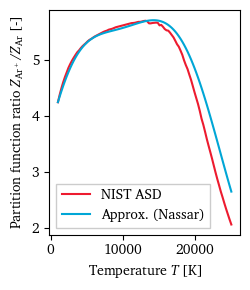

In [3]:
pfr_poly = saha.get_argon_pfr(temperature)

part = Partition(gas_species)
part.get_stored_data()  # Must call get_web_data method first to download this
pfr = part.get_ratio('Ar II', 'Ar I', temperature)

plt.figure(figsize=(2.6,3))
plt.plot(temperature, pfr, label='NIST ASD')
plt.plot(temperature, pfr_poly, label='Approx. (Nassar)')
plt.xlabel(r'Temperature $T$ [K]')
plt.ylabel(r'Partition function ratio $Z_{\mathrm{Ar}^+}/Z_\mathrm{Ar}$ [-]')
plt.legend()
plt.tight_layout()
if SAVE_PLOT: plt.savefig('../report/assets/4 models/partition.pdf')
plt.show()

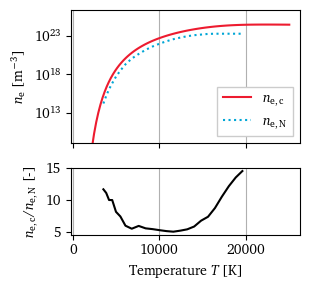

2.6322500007133325e+24


In [4]:
ionization_mode = 'regular'

ndata = np.loadtxt('../rawdata/akarapu_n.csv', delimiter=',')
CEA_T, CEA_a = CEA.get_ionization(int(pressure/1e5))

if ionization_mode == 'simple':
    alphas = saha.degreeIonization_simple(temperature, pressure, Ei_Argon)
    n_e = alphas*n_0
elif ionization_mode == 'regular':
    n_e = saha.degreeIonization(temperature, Ei_Argon, n_0, pfr)
    alphas = n_e/n_0
elif ionization_mode == 'literature_fit':
    popt, pcov = sciopt.curve_fit(
        lambda x, c1, c2: saha.curvefit(x, c1, c2, n_0),
        ndata[:,0],
        ndata[:,1]
    )
    n_e = saha.curvefit(temperature, popt[0], popt[1], n_0)
    alphas = n_e/n_0
elif ionization_mode == 'literature_interp':
    n_e = np.interp(temperature, ndata[:,0], ndata[:,1])
    alphas = n_e/n_0
# elif ionization_mode == 'chianti':
#     n_e = saha.degreeIonization_chianti(temperature, n_0, 18)
#     alphas = n_e/n_0

# plt.plot(temperature, alphas, label='Saha')
# # plt.plot(ndata[:,0], ndata[:,1]/n_0, label='Akarapu et al.')
# # # plt.plot(CEA_T, CEA_a, 'r:.', label='CEA at {} bar'.format(int(pressure/1e5)))
# plt.legend()
# plt.show()
fig, axes = plt.subplots(2,1, height_ratios=[2,1], sharex=True, figsize=(3.2,3))
fig.subplots_adjust(hspace=0.1)
axes[0].semilogy(temperature, n_e, label=r'$n_\mathrm{e,c}$')
axes[0].semilogy(ndata[:,0], ndata[:,1], ':', label=r'$n_\mathrm{e,N}$')
# plt.semilogy(CEA_T, CEA_a*n_0, 'r:.', label='CEA at {} bar'.format(int(pressure/1e5)))
axes[0].set_ylabel(r'$n_\mathrm{e}$ [m$^{-3}$]')
axes[0].set_ylim(bottom=1e9)
axes[0].legend()
axes[0].grid(axis='x')

axes[1].plot(ndata[:,0], 
         saha.degreeIonization(
             ndata[:,0], 
             Ei_Argon, 
             pressure*const.N_A/(const.R*ndata[:,0]), 
            #  part.get_ratio('Ar II', 'Ar I', ndata[:,0])
             saha.get_argon_pfr(ndata[:,0])
             )/ndata[:,1],
             '-k'
        )
axes[1].set_xlabel(r'Temperature $T$ [K]')
axes[1].set_ylabel(r'$n_\mathrm{e,c}/n_\mathrm{e,N}$ [-]')
axes[1].grid(axis='x')
plt.tight_layout()
if SAVE_PLOT and pressure == 1e5 : plt.savefig('../report/assets/4 models/n_e.pdf')
plt.show()

print(n_e[-1])
# temperature = ndata[:,0]
# n_e = ndata[:,1]

## Figure 2: Inverse-Bremsstrahlung Absorption
We then compute the absorption coefficient by inverse-bremsstrahlung using the following equation:
$$
    \alpha = \frac{7.8\times 10^{-7}Zn_\mathrm{e}^2\ln{\Lambda}}{\nu^2T_\mathrm{e}^{3/2}} \left(1-\frac{\nu_\mathrm{p}^2}{\nu^2}\right)^{-1/2}
$$
Where (from [1], original equation given in [4]):
- $\alpha$ is the absorption coefficient [1/m]
- $Z$ is the ionic charge, and is set to 1 for single ionization
- $n_\mathrm{e}$ is calculated from the previous step [cm^-3]
- $\ln{\Lambda} \approx 23-\ln{(n_\mathrm{e}^{1/2}ZT_\mathrm{e}^{-3/2})}$ [2] page 34
- $T_\mathrm{e}$ is the electron temperature [eV]
- $\nu$ is the laser frequency
- $\nu_\mathrm{p} \sim 8980\sqrt{n_\mathrm{e}}$ is the plasma frequency, for electron density expressed in cm^-3 [3]



### Aside: Where does 8980 come from?
The equation for plasma frequency (angular) is as follows, yielding a value in rad/s when using a consistent system of units:
$$
    \omega_\mathrm{pe}^2 = \frac{n_\mathrm{e}e^2}{\epsilon_0 m_\mathrm{e}}
$$
A frequency in Hz is often used and more practical. We can get it by dividing the angular frequency by $2\pi$:
$$
    f_\mathrm{pe} = \frac{\omega_\mathrm{pe}}{2\pi} = \frac{1}{2\pi}\sqrt{\frac{n_\mathrm{e}e^2}{\epsilon_0 m_\mathrm{e}}}
$$
Since most parameters are constants, we can group them up:
$$
    f_\mathrm{pe} = \frac{1}{2\pi}\sqrt{\frac{e^2}{\epsilon_0 m_\mathrm{e}}}\sqrt{n_\mathrm{e}}
$$
Turns out they evaluate to the following in SI units:
$$
    \frac{1}{2\pi}\sqrt{\frac{e^2}{\epsilon_0 m_\mathrm{e}}} = \biggl\{
        \begin{array}{l}
            8.97885\;\text{m}^{3/2}\text{s}^{-1} \\
            8978.85\;\text{cm}^{3/2}\text{s}^{-1} 
        \end{array}
$$



### Problem
$\ln{\Lambda} \approx 23-\ln{(n_\mathrm{e}^{1/2}ZT_\mathrm{e}^{-3/2})}$ is not really valid... Johnston and Dawson [1] state the following:

> at frequencies well above the plasma frequency $\nu_\mathrm{p}$, $\ln{\Lambda}(\nu)$ should contain the wave frequency $\nu$ rather than the plasma frequency $\nu_\mathrm{p}$.

When we plot our frequencies:

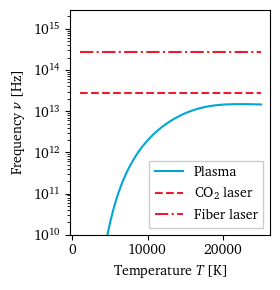

In [5]:
laser_freq = CO2_freq
laser_freq = Fiber_freq

n_e_cm = n_e*100**-3  # Conversion from m^-3 to cm^-3
Z = 1  # not 100% sure about this
T_e = temperature/11604  # eV

plasma_freq = lambda ne_cm: 8978.85*np.sqrt(ne_cm)
plt.figure(figsize=(2.9,3))
plt.plot([],[])
plt.semilogy(temperature, plasma_freq(n_e_cm), label="Plasma")
plt.plot(temperature, CO2_freq*np.ones(temperature.shape), '--', 
         label=r"CO$_2$ laser", color='#ed1b2f')
plt.plot(temperature, Fiber_freq*np.ones(temperature.shape), '-.', 
         label="Fiber laser", color='#ed1b2f')
plt.xlabel(r'Temperature $T$ [K]')
plt.ylabel(r'Frequency $\nu$ [Hz]')
plt.ylim(1e10)
plt.legend()
plt.tight_layout()
if SAVE_PLOT: plt.savefig('../report/assets/4 models/frequency_comparison.pdf')
plt.show()

We're well beyond the plasma frequency at fiber laser frequencies!

Furthermore:

$$\Lambda(\nu) = \min{\left(\frac{v_T}{\omega_\mathrm{p}\rho_\mathrm{min}}, \frac{v_T}{\omega\rho_\mathrm{min}}\right)}$$

Where $v_T$ is the thermal velocity of the electrons, and $\rho_\mathrm{min}$ is the minimum impact parameters of electron-ion collisions, which can be approximated as

$$\rho_\mathrm{min} \approx \max{\left(\frac{Ze^2}{k_BT}, \frac{\hbar}{(m_\mathrm{e}k_BT)^{1/2}}\right)}$$

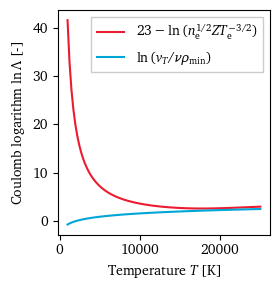

In [6]:
coulombLog = lambda ne, Te: 23 - np.log(ne**0.5*Z*Te**-1.5)

def big_lambda(temperature, n_e_cm, laser_freq):
    thermal_velocity = np.sqrt(const.Boltzmann*temperature/const.m_e)
    rho_min = np.maximum(
        Z*const.elementary_charge**2/(const.Boltzmann*temperature),
        const.Planck/(2*np.pi*np.sqrt(const.m_e*const.Boltzmann*temperature)))
    omega = np.maximum(plasma_freq(n_e_cm), laser_freq)  #*(2*np.pi)
    return thermal_velocity/(omega*rho_min)

lnLambda = np.log(big_lambda(temperature, n_e_cm, laser_freq))
# lnLambda = coulombLog(n_e_cm, T_e)

plt.figure(figsize=(2.9,3))
plt.plot(temperature, coulombLog(n_e_cm, T_e),
         label=r'$23-\ln{(n_\mathrm{e}^{1/2}ZT_\mathrm{e}^{-3/2})}$')
plt.plot(temperature, np.log(big_lambda(temperature, n_e_cm, laser_freq)),
         label=r'$\ln{(v_T/\nu\rho_\mathrm{min})}$')
plt.xlabel(r'Temperature $T$ [K]')
plt.ylabel(r'Coulomb logarithm $\ln{\Lambda}$ [-]')
plt.legend()
plt.tight_layout()
if SAVE_PLOT: plt.savefig('../report/assets/4 models/coulombLog.pdf')
plt.show()


Maximum: 8.96 m^-1 at 19182 K
Maximum: 21.29 m^-1 at 19909 K
Maximum: 67.40 m^-1 at 21121 K
Maximum: 130.21 m^-1 at 21606 K
Maximum: 206.55 m^-1 at 22091 K


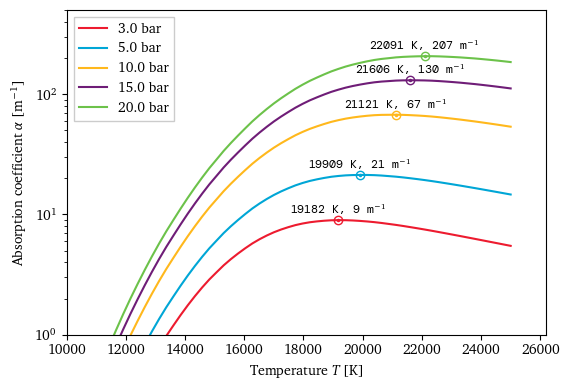

In [24]:
plt.figure(figsize=(5.8,4))
ps = [3e5, 5e5, 10e5, 15e5, 20e5]

matsuimodel = np.loadtxt('../rawdata/matsuiModel.csv', delimiter=',')

peaktemps = []
peakalphas = []
for i, p in enumerate(ps):
    n_0 = p*const.N_A/(const.R*temperature)
    n_e = saha.degreeIonization(temperature, Ei_Argon, n_0, pfr)
    n_e_cm = n_e*100**-3
    lnLambda = np.log(big_lambda(temperature, n_e_cm, laser_freq))
    absorption = 7.8e-7*Z*n_e_cm**2*lnLambda \
        / (laser_freq**2*T_e**1.5) \
        * (1-(plasma_freq(n_e_cm)/laser_freq)**2)**-0.5
    peakidx = np.argmax(absorption)
    mT, ma = (temperature[peakidx], absorption[peakidx])
    print('Maximum: {:.2f} m^-1 at {:.0f} K'.format(absorption[peakidx], temperature[peakidx]))
    plt.semilogy(temperature, absorption, label='{:.1f} bar'.format(p*1e-5))
    plt.semilogy(mT, ma, 'C{}.'.format(i), markersize=3)
    plt.semilogy(mT, ma, 'C{}o'.format(i), mfc=(0,0,0,0), mec='C{}'.format(i))
    plt.annotate('{:.0f} K, {:.0f}'.format(mT, ma)+r' m$^{-1}$', (mT, ma), 
                 xytext=(0,0.25), textcoords='offset fontsize', va='bottom',
                 fontfamily='monospace', fontsize='small', 
                #  color='C'+str(i),
                 ha='center')
xlims = plt.xlim()
# plt.plot(matsuimodel[:,0], matsuimodel[:,1], ':k', label='10.0 bar (Matsui)')
plt.xlim(10000)
plt.ylim(1, 500)
plt.xlabel(r'Temperature $T$ [K]')
plt.ylabel(r'Absorption coefficient $\alpha$ [m$^{-1}$]')
plt.legend()
plt.tight_layout()
if SAVE_PLOT:
    plt.savefig('../report/assets/4 models/absorption.pdf')
    plt.savefig('../report/assets/4 models/absorption.png', dpi=72)
plt.show()

## References
1. Akarapu, R., Abdalla Ramadan Nassar, S. M. Copley, and J. A. Todd. ["Numerical model of a laser-sustained argon plasma."](https://doi.org/10.2351/1.3263120) *Journal of Laser Applications* 21, no. 4 (2009): 169-175.  
2. Nassar, Abdalla Ramadan. ["Investigation of laser-sustained plasma and the role of plasma in carbon dioxide laser nitriding of titanium."](https://etda.libraries.psu.edu/catalog/16162) (2012).
3. NRL Plasma Formulary  
4. Gurnett, Donald A., and Amitava Bhattacharjee. *Introduction to plasma physics: With space, laboratory and astrophysical applications*. Cambridge University Press, 2017.  
5. Johnston, Tudor Wyatt, and John M. Dawson. ["Correct values for high‐frequency power absorption by inverse bremsstrahlung in plasmas."](https://doi.org/10.1063/1.1694419) *The Physics of Fluids* 16, no. 5 (1973): 722-722.